In [9]:
import json
import matplotlib.pyplot as plt

In [10]:

# Read the file and load JSON data
with open('responses.txt', 'r') as file:
    data = [json.loads(line) for line in file]

In [11]:

# Count occurrences of each server
server_counts = {}
for entry in data:
    server_name = entry["message"].split(":")[1]
    if server_name in server_counts:
        server_counts[server_name] += 1
    else:
        server_counts[server_name] = 1


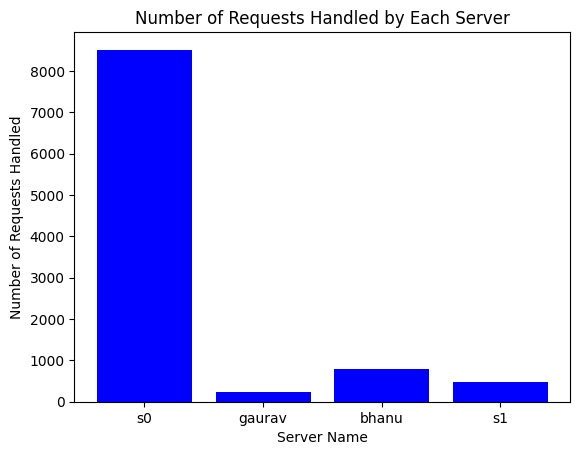

In [12]:

# Plot the bar graph
servers = list(server_counts.keys())
counts = list(server_counts.values())

plt.bar(servers, counts, color='blue')
plt.xlabel('Server Name')
plt.ylabel('Number of Requests Handled')
plt.title('Number of Requests Handled by Each Server')
plt.show()
